# Dataset preprocessing and augmentation 
The dataset contains labeled images and corresponding ground-truth masks that indicate which pixels belong to which object or category. Make sure you familiarize yourself with the dataset structure (train/validation/test splits, image dimensions, mask formats, label classes, etc.). 

1.  Initially,  the  images  in  this  dataset  might  have  different  dimensions,  you  are  required  to  resize the image to make them consistent for training.  
2.  Data augmentation: please implement data augmentation techniques as you see fit to increase your  segmentation  performance.  These  techniques  include  but  are  not  limited  to  flipping, rotation, translation, elastic transformations, color jitter, random cropping.

## Image Resizing

Analyse image sizes across images

In [1]:
import imagesize
import os
import numpy as np
import cv2
from collections import Counter
from tqdm import tqdm

In [2]:
# Print all kinds of image formats in dataset 
def print_image_formats():
    image_formats = set()
    for root, dirs, files in os.walk('dataset/images'):
        for file in tqdm(files):
            if (not os.path.isdir(file)):
                image_formats.add(file.split('.')[-1])
    print(image_formats)

print_image_formats() # {'jpg', 'mat'}

100%|██████████| 7393/7393 [00:00<00:00, 40142.88it/s]

{'jpg', 'mat'}


In [3]:
def get_image_sizes(path):
    image_sizes = []
    image_areas = []
    for root, dirs, files in os.walk(path):
        for file in tqdm(files):
            if not os.path.isdir(file):
                if file.endswith('.mat'):
                    img = cv2.imread(os.path.join(root, file))
                    if img is not None:
                        h, w = img.shape[:2]
                    else:
                        continue
                else:
                    w, h = imagesize.get(os.path.join(root, file))

                image_sizes.append((w, h))
                image_areas.append(w * h)
    return image_sizes, image_areas

image_sizes, image_areas = get_image_sizes('dataset/images')

 30%|███       | 2246/7393 [00:18<00:41, 122.93it/s]


KeyboardInterrupt: 

In [ ]:
# Top 5 most common dimensions
counter = Counter(image_sizes)
print(f"Top 5 most common dimensions: {counter.most_common(5)}")

# Smallest dimension
min_dim = min(min(image_sizes, key=lambda x: min(x[0],x[1])))
print(f"Smallest dimension: {min_dim}")

# Largest dimension
max_dim = max(max(image_sizes, key=lambda x: max(x[0],x[1])))
print(f"Largest dimension: {max_dim}")

# Average Dimension
avg_dim = np.mean(image_sizes, axis=0)
print(f"Average Dimension: {avg_dim}")

# Average Area
avg_area = np.mean(image_areas)
sqrt_avg_area = int(np.sqrt(avg_area))
print(f"Average Area: {avg_area}")
print(f"Square root of Average Area: {sqrt_avg_area}")

# Top 5 most common dimensions: [((500, 375), 1425), ((500, 333), 1072), ((375, 500), 511), ((333, 500), 509), ((300, 225), 266)]
# Smallest dimension: 103
# Largest dimension: 3264
# Average Dimension: [436.74519621 390.91366712]
# Average Area: 174861.48240866035
# Square root of Average Area: 418


# Best resize dimension is 256x256
# Prevents excessive upscaling of small images.
# Keeps computational efficiency reasonable.
# Maintains a square format for neural networks.
# Avoids unnecessary interpolation artifacts.


Top 5 most common dimensions: [((500, 375), 1425), ((500, 333), 1072), ((375, 500), 511), ((333, 500), 509), ((300, 225), 266)]
Smallest dimension: 103
Largest dimension: 3264
Average Dimension: [436.74519621 390.91366712]
Average Area: 174861.48240866035
Square root of Average Area: 418


In [5]:
def image_path_to_annotation_path(image_path):
    arr = image_path.split(os.sep)
    arr[1] = os.path.join('annotations', 'trimaps')
    arr[2] = os.path.splitext(arr[2])[0] + '.png'
    return os.sep.join(arr)

def get_image_paths():
    image_paths = []
    for root, dirs, files in os.walk('dataset\images'):
        for file in tqdm(files):
            if not os.path.isdir(file):
                img_path = os.path.join(root, file)     
                annotation_path = image_path_to_annotation_path(img_path)

                image_paths.append((img_path, annotation_path))
    return image_paths

image_paths = get_image_paths()

print(image_paths[:5])
print(len(image_paths))


100%|██████████| 7393/7393 [00:00<00:00, 40596.38it/s]

[('dataset\\images\\Abyssinian_1.jpg', 'dataset\\annotations\\trimaps\\Abyssinian_1.png'), ('dataset\\images\\Abyssinian_10.jpg', 'dataset\\annotations\\trimaps\\Abyssinian_10.png'), ('dataset\\images\\Abyssinian_100.jpg', 'dataset\\annotations\\trimaps\\Abyssinian_100.png'), ('dataset\\images\\Abyssinian_100.mat', 'dataset\\annotations\\trimaps\\Abyssinian_100.png'), ('dataset\\images\\Abyssinian_101.jpg', 'dataset\\annotations\\trimaps\\Abyssinian_101.png')]
7393


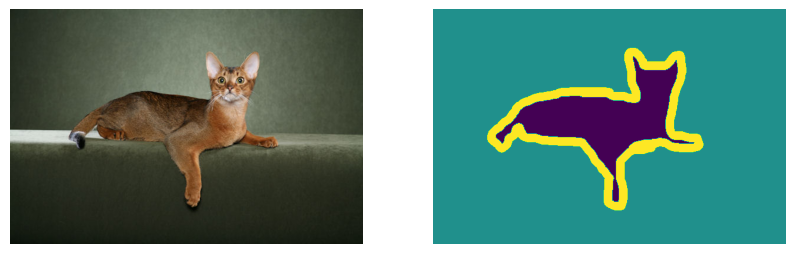

In [6]:
from PIL import Image
import matplotlib.pyplot as plt

def display_image_path(image_path, annotation_path=None):
    if annotation_path is not None:
        fig, ax = plt.subplots(1, 2, figsize=(10, 5))
        ax[0].imshow(Image.open(image_path))
        ax[1].imshow(Image.open(annotation_path))
        ax[0].axis('off')
        ax[1].axis('off')
    else:
        plt.imshow(Image.open(image_path))
        plt.axis('off')
    plt.show()

def display_image(image, annotation = None):

    if annotation is not None:
        fig, ax = plt.subplots(1, 2, figsize=(10, 5))
        ax[0].imshow(image)
        ax[1].imshow(annotation)
        ax[0].axis('off')
        ax[1].axis('off')
    else:
        plt.imshow(image)
        plt.axis('off')
    plt.show()

display_image_path(image_paths[0][0], image_paths[0][1])


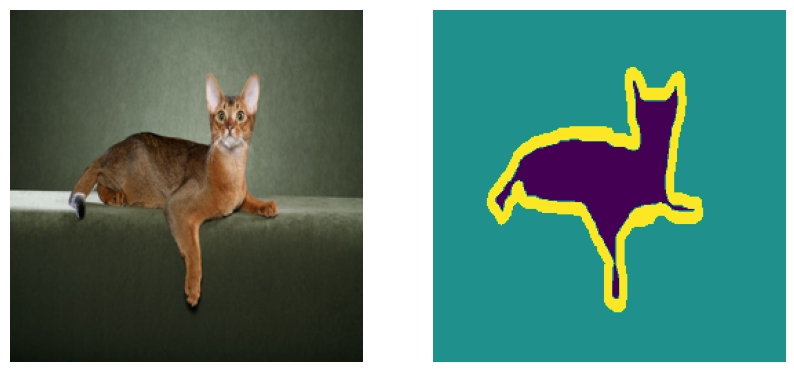

In [7]:

def resize_image(image_path, annotation_path, size=(256, 256)):
    img = Image.open(image_path)
    annotation = Image.open(annotation_path)
    img_resized = img.resize(size)
    annotation_resized = annotation.resize(size)
    return img_resized, annotation_resized

img_resized, annotation_resized = resize_image(image_paths[0][0], image_paths[0][1])

display_image(img_resized, annotation_resized)

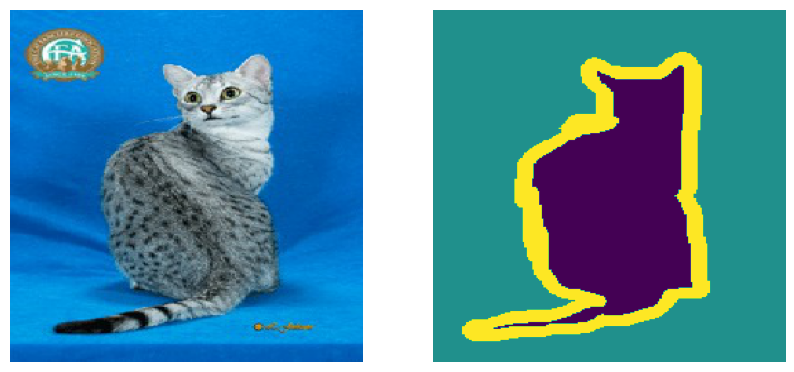

[1 2 3]


In [143]:
import albumentations as A
from albumentations.pytorch import ToTensorV2
import random

dim = 256

# Define the augmen5ation pipeline
augmentation_pipeline = A.Compose([
    A.ElasticTransform(alpha=10, sigma=20, p=0.5, border_mode=cv2.BORDER_REFLECT_101),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.Affine(translate_percent=0.05, scale=(0.9, 1.1), rotate=(-30, 30), p=0.5, cval=0, mode=cv2.BORDER_CONSTANT),
    A.Resize(dim, dim, interpolation=cv2.INTER_NEAREST),  # Ensure no interpolation in segmentation mask
    ToTensorV2()
])

def augment_image(image, annotation):
    augmented = augmentation_pipeline(image=image, mask=annotation)
    return augmented['image'], augmented['mask']

i = random.randint(0, len(image_paths))

image = np.array(Image.open(image_paths[i][0]))
annotation = np.array(Image.open(image_paths[i][1]))

augmented_image, augmented_annotation = augment_image(image, annotation)

# replace 0 with 2 in the annotation to retain the original background class
augmented_annotation[augmented_annotation == 0] = 2

display_image(augmented_image.permute(1, 2, 0).numpy(), augmented_annotation.numpy())

# print values of annotations
print(np.unique(augmented_annotation))

In [146]:
import scipy.io

dim = 128

trainval = 'dataset/annotations/trainval.txt' # contains list of image paths for training and validation

# read the file and augment the images and annotations and store them in the augmented folder

if not os.path.exists(f'trainval_{dim}'):
    os.makedirs(os.path.join(f'trainval_{dim}', 'images'))
    os.makedirs(os.path.join(f'trainval_{dim}', 'annotations'))

with open(trainval, 'r') as f:
    lines = f.readlines()

for line in tqdm(lines):
    image_file = line.split()[0]
    image_path = os.path.join('dataset', 'images', image_file + '.jpg')
    if not os.path.exists(image_path):
        image_path = image_path.replace('.jpg', '.mat')
    
    annotation_path = os.path.join('dataset', 'annotations', 'trimaps', image_file + '.png')

    if image_path.endswith('.mat'):
        mat = scipy.io.loadmat(image_path)
        image = mat['image']  # Adjust the key based on the actual structure of your .mat file
    else:
        image = np.array(Image.open(image_path))
    
    annotation = np.array(Image.open(annotation_path))

    aug_image, aug_annotation = augment_image(image, annotation)

    # replace 0 with 2 in the annotation to retain the original background class
    aug_annotation[aug_annotation == 0] = 2

    aug_image_path = os.path.join(f'trainval_{dim}', 'images', image_file + '.png')
    aug_annotation_path = os.path.join(f'trainval_{dim}', 'annotations', image_file + '.png')

    aug_image_rgb = Image.fromarray(aug_image.permute(1, 2, 0).numpy()).convert('RGB')
    aug_image_rgb.save(aug_image_path)

    Image.fromarray(aug_annotation.numpy()).save(aug_annotation_path)

100%|██████████| 3680/3680 [02:14<00:00, 27.32it/s]


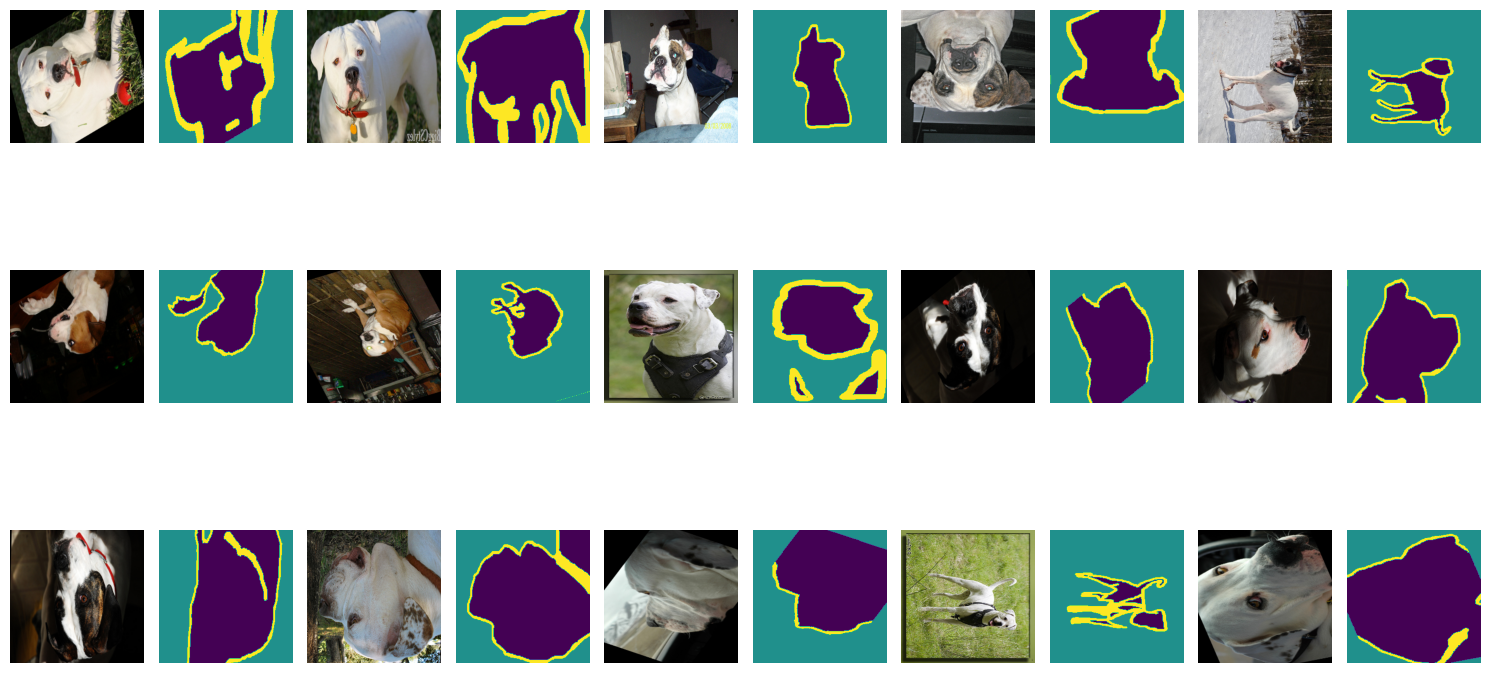

In [10]:
# show off 15 augmentations (3*5) with trimaps

fig, axes = plt.subplots(3, 10, figsize=(15, 9))
for i in range(15):
    
    image = np.array(Image.open(image_paths[i+250][0]))
    annotation = np.array(Image.open(image_paths[i+250][1]))
    aug_image, aug_annotation = augment_image(image, annotation)
    aug_annotation[aug_annotation == 0] = 2
    
    axes[i // 5, (i % 5) * 2].imshow(aug_image.permute(1, 2, 0).numpy())
    axes[i // 5, (i % 5) * 2].axis('off')
    axes[i // 5, (i % 5) * 2 + 1].imshow(aug_annotation.numpy())
    axes[i // 5, (i % 5) * 2 + 1].axis('off')

plt.tight_layout()
plt.show()


In [11]:
# Make array for test set image paths and annotations to be saved in a pickle

test = 'dataset/annotations/test.txt' # contains list of image paths for testing

test_image_paths = []
test_trimap_paths = []

with open(test, 'r') as f:
    lines = f.readlines()

for line in tqdm(lines):
    image_file = line.split()[0]
    image_path = os.path.join('dataset', 'images', image_file + '.jpg')
    if not os.path.exists(image_path):
        image_path = image_path.replace('.jpg', '.mat')
    
    annotation_path = os.path.join('dataset', 'annotations', 'trimaps', image_file + '.png')

    test_image_paths.append(image_path)
    test_trimap_paths.append(annotation_path)

# Save
import pickle

with open('test_image_paths.pkl', 'wb') as f:
    pickle.dump(sorted(test_image_paths), f)

with open('test_trimap_paths.pkl', 'wb') as f:
    pickle.dump(sorted(test_trimap_paths), f)

print(test_image_paths[:5])
print(test_trimap_paths[:5])


100%|██████████| 3669/3669 [00:00<00:00, 11230.59it/s]

['dataset\\images\\Abyssinian_201.jpg', 'dataset\\images\\Abyssinian_202.jpg', 'dataset\\images\\Abyssinian_204.jpg', 'dataset\\images\\Abyssinian_205.jpg', 'dataset\\images\\Abyssinian_206.jpg']
['dataset\\annotations\\trimaps\\Abyssinian_201.png', 'dataset\\annotations\\trimaps\\Abyssinian_202.png', 'dataset\\annotations\\trimaps\\Abyssinian_204.png', 'dataset\\annotations\\trimaps\\Abyssinian_205.png', 'dataset\\annotations\\trimaps\\Abyssinian_206.png']


In [12]:
print(len(test_image_paths))

3669
